In [31]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn import preprocessing, svm, metrics, decomposition
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.model_selection import train_test_split, KFold
import pickle

In [3]:
# Import data from csv
'''
%%time
stations = pd.read_csv('data_raw/babs_open_data_year_3/201608_station_data.csv', skipinitialspace= True)
status = pd.read_csv('data_raw/babs_open_data_year_3/201608_status_data.csv', 
                     parse_dates = [3], infer_datetime_format = True, skipinitialspace= True)
trips = pd.read_csv('data_raw/babs_open_data_year_3/201608_trip_data.csv', 
                   parse_dates = ['Start Date', 'End Date'], infer_datetime_format = True, skipinitialspace= True)
weathers = pd.read_csv('data_raw/babs_open_data_year_3/201608_weather_data.csv',
                      parse_dates = ['PDT'], infer_datetime_format = True, skipinitialspace= True)
'''

"\n%%time\nstations = pd.read_csv('data_raw/babs_open_data_year_3/201608_station_data.csv', skipinitialspace= True)\nstatus = pd.read_csv('data_raw/babs_open_data_year_3/201608_status_data.csv', \n                     parse_dates = [3], infer_datetime_format = True, skipinitialspace= True)\ntrips = pd.read_csv('data_raw/babs_open_data_year_3/201608_trip_data.csv', \n                   parse_dates = ['Start Date', 'End Date'], infer_datetime_format = True, skipinitialspace= True)\nweathers = pd.read_csv('data_raw/babs_open_data_year_3/201608_weather_data.csv',\n                      parse_dates = ['PDT'], infer_datetime_format = True, skipinitialspace= True)\n"

In [4]:
# Drop missing data where the columns or rows are nan
'''
stations = stations.dropna(how = 'all')
status = status.dropna(how = 'all')
trips = trips.dropna(how = 'all')
weathers = weathers.dropna(how = 'all')
'''

"\nstations = stations.dropna(how = 'all')\nstatus = status.dropna(how = 'all')\ntrips = trips.dropna(how = 'all')\nweathers = weathers.dropna(how = 'all')\n"

In [5]:
# Save the dataframe objects into files with pickle, saving time for loading the file
'''
stationfile = open("data_cleaned/stations_data_year3","wb")
tripfile = open("data_cleaned/trips_data_yaer3","wb")
weatherfile = open("data_cleaned/weathers_data_year3","wb")
statusfile = open("data_cleaned/status_data_year3","wb")
pickle.dump(stations, stationfile)
pickle.dump(trips, tripfile)
pickle.dump(weathers, weatherfile)
pickle.dump(status, statusfile)
stationfile.close()
tripfile.close()
weatherfile.close()
statusfile.close()
'''

'\nstationfile = open("data_cleaned/stations_data","wb")\ntripfile = open("data_cleaned/trips_data","wb")\nweatherfile = open("data_cleaned/weathers_data","wb")\nstatusfile = open("data_cleaned/status_data","wb")\npickle.dump(stations, stationfile)\npickle.dump(trips, tripfile)\npickle.dump(weathers, weatherfile)\npickle.dump(status, statusfile)\nstationfile.close()\ntripfile.close()\nweatherfile.close()\nstatusfile.close()\n'

In [6]:
# Load data from pickled file
#%%time
stationfile = open("data_cleaned/stations_data_year3","rb")
tripfile = open("data_cleaned/trips_data_year3","rb")
weatherfile = open("data_cleaned/weathers_data_year3","rb")
statusfile = open("data_cleaned/status_data_year3","rb")
stations = pickle.load(stationfile)
trips = pickle.load(tripfile)
weathers = pickle.load(weatherfile)
status = pickle.load(statusfile)
cal = calendar()
holidays = cal.holidays(start = trips['Start Date'].min(), end = trips['Start Date'].max())

# Introduction

The purpose of this document is to predict the demand of each station in a giving time.
The procedures are as followed:
1. Define 'demand' as number of bike borrowed from one station in a given time period. We'll further classified the demand to 5 levels, from 1 to 5, each will represent 20% quantile of the demand distribution.

2. From the previous data exploration, we've identified that the station(location), date, time and temperature are the important factors impacting the demand. We'll use those factors to train the data.

3. We'll train the model using the dataset in 2016. However, we'll expend the training set to the datasets from 2013 to 2016.

# Define demand
We'll define demand as number of bike will be borrowed in the future 15 minutes. Therefore, we will have 4 period in each hour. 

In [7]:
# Define demand column by counting the number of bike borrowed in particular station in the next 1 Hour
t = trips.set_index('Start Date')
t = t.groupby([pd.TimeGrouper('H'), 'Start Terminal']).size().unstack('Start Terminal').fillna(0)
t = t.stack().reset_index('Start Terminal')
t = t.rename(columns = {0: 'Demand'})

# Parse out the time details
t['year'] = t.index.year
t['month'] = t.index.month
t['day'] = t.index.day
t['hour'] = t.index.hour
t['min'] = t.index.minute

# Set up workday
t['PDT'] = t.index.date
t['PDT'] = pd.to_datetime(t.PDT)
t = t.reset_index()
weekday = t['Start Date'].dt.weekday
t['workday'] = weekday.isin([0,1,2,3,4]) & (t.PDT.isin(holidays) == False)

In [8]:
# Clean data in weathers  
w = weathers
w.PrecipitationIn = w.PrecipitationIn.replace('T', '0.005')
w.PrecipitationIn = pd.to_numeric(w.PrecipitationIn)
w = w.drop(['Max Gust SpeedMPH', 'Events'], axis = 'columns')
w = w.fillna(w.mean())
ziplocation = {94107:'San Francisco', 94301:'Palo Alto', 94041:'Mountain View', 95113:'San Jose'}
w['landmark'] = w.ZIP.map(ziplocation)

# Join data with stations and weathers
s = stations.set_index('station_id').loc[:, ['lat', 'long', 'dockcount', 'landmark']]
m = pd.merge(t, s, how ='inner', left_on='Start Terminal', right_index= True)

m = pd.merge(m, w, how ='inner', left_on = ['PDT', 'landmark'], right_on = ['PDT', 'landmark'])
m = m.dropna(axis =1, how='all')

In [9]:
# First predict smaller dataset for validating the model
# Predict the 3 most demanded stations
t_station = m.groupby(by = 'Start Terminal').sum().sort_values(by = 'Demand', ascending = False).index.tolist()[:3]
m = m[m['Start Terminal'].isin(t_station)]

In [10]:
# Parse the features to X, label to y
X = m.drop(['Start Date', 'PDT','min','Demand','year','Max VisibilityMiles','dockcount','ZIP'], axis = 1)
X = pd.get_dummies(X, prefix= ['workday','landmark'], columns = ['workday','landmark'], drop_first=True)
X = X.as_matrix()
y = m.Demand.as_matrix()

In [11]:
np.shape(X)

(23688, 26)

In [12]:
#Reduce dimension of features by using PCA
pca = decomposition.PCA()
Xn = pca.fit_transform(X)

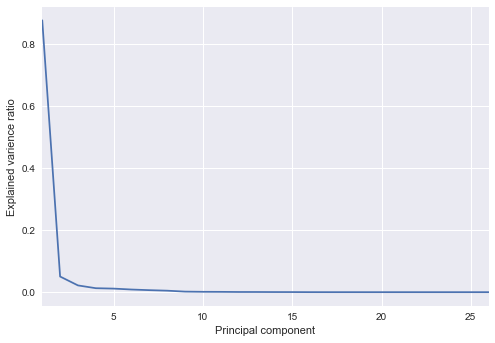

In [13]:
# Analyze the 'explained varience ratio' to each 'Principal Component'
x_pca = list(range(1,27))
y_v = pca.explained_variance_ratio_
plt.plot(x_pca, y_v)
plt.xlabel('Principal component')
plt.ylabel('Explained varience ratio')
plt.xlim(1,26);

Total explained varience ratio using 5 principal component: 96.29 %


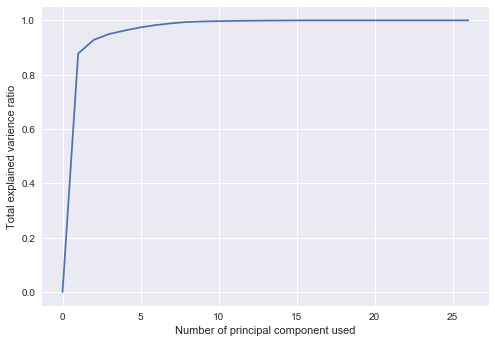

In [14]:
sumv = [0]
x_pca = list(range(0,27))
for i in range(len(y_v)):
    sumv.append(sum(y_v[:i+1]))
plt.plot(x_pca, sumv);
plt.xlabel('Number of principal component used');
plt.ylabel('Total explained varience ratio');
print('Total explained varience ratio using 5 principal component:',round(sumv[4]*100,2),'%')

In [15]:
pca = decomposition.PCA(n_components=5)
Xn = pca.fit_transform(X)

In [16]:
# Categorize demand into three category, no demand = 0, normal = 1~5, high demand = >5
def catg(y):
    if y == 0:
        return 0
    elif y<=5:
        return 1
    else:
        return 2

y = np.array(list(map(catg, y)))

In [17]:
# normalize data
scl= preprocessing.StandardScaler()
Xn = scl.fit_transform(Xn)

In [18]:
Xlr, Xtestlr, ylr, ytestlr = train_test_split(Xn, y)

In [19]:
# Define function for cross validation test
def cv_score(clf, x, y, score_func=metrics.accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train], sample_weight= (y[train]+1)) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [20]:
# Find the best gamma and C

Cs = [1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]
Gs = np.arange(0.1, 2, 0.2)
score = pd.DataFrame(index=Gs, columns = Cs)

for c in Cs:
    for g in Gs:
        clf = svm.SVC(gamma = g, C = c, max_iter=100)
        score.loc[g,c] = cv_score(clf, Xlr, ylr)

score

/Users/Robin/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


,1,10,100,1000,10000,100000,1000000,10000000,100000000
0.1,0.157099,0.338399,0.386581,0.402231,0.419847,0.421761,0.41574,0.419565,0.422886
0.3,0.268319,0.391871,0.450018,0.4521,0.439381,0.430766,0.454297,0.433808,0.447541
0.5,0.251428,0.383766,0.447543,0.4248,0.451708,0.452495,0.439886,0.446699,0.453454
0.7,0.311053,0.403408,0.410052,0.406057,0.460993,0.455366,0.449172,0.446527,0.453788
0.9,0.232683,0.346277,0.44349,0.42052,0.447541,0.445289,0.455254,0.463584,0.463584
1.1,0.23281,0.409041,0.448329,0.410344,0.413554,0.429979,0.463751,0.470168,0.470168
1.3,0.184344,0.39525,0.451425,0.433414,0.394232,0.460882,0.462963,0.428355,0.428017
1.5,0.235568,0.407296,0.385173,0.445738,0.461275,0.453001,0.456153,0.446639,0.441742
1.7,0.284301,0.435385,0.422325,0.420971,0.447709,0.416242,0.419183,0.418338,0.418338
1.9,0.237298,0.401723,0.411964,0.4615,0.447314,0.45497,0.414444,0.465609,0.464033


In [21]:
clf = svm.SVC(gamma = 1.7, C=1000000, max_iter=1000000)

In [22]:
%%time
clf.fit(Xlr,ylr)

CPU times: user 6min 37s, sys: 9.66 s, total: 6min 47s
Wall time: 10min 55s


/Users/Robin/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1000000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1.7, kernel='rbf',
  max_iter=1000000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
predicted = clf.predict(Xtestlr)
print(metrics.classification_report(predicted,ytestlr))

             precision    recall  f1-score   support

          0       0.60      0.52      0.55      3290
          1       0.47      0.45      0.46      2396
          2       0.02      0.08      0.04       236

avg / total       0.52      0.47      0.49      5922



In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytestlr, predicted)

array([[1696,  990,  151],
       [1168, 1079,   67],
       [ 426,  327,   18]])

In [48]:
hour = m.hour.as_matrix()
terminal = m['Start Terminal'].as_matrix()
c = m.Demand
c = np.array(list(map(catg, c)))

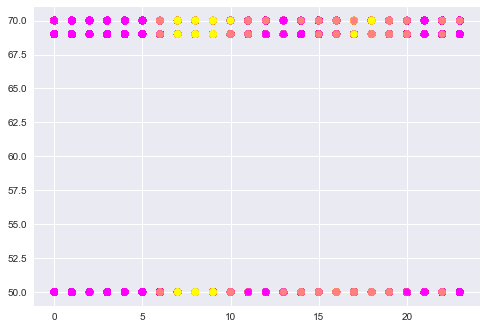

In [51]:
plt.scatter(x = hour, y = terminal, c=c, s= 50, cmap='spring')